# Profiling and optimizing Python code

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

Suppose that we want to create a downsampled version of a certain image...

...and want to do that as fast as possible.

Let's start by using a toy image for testing purposes:

In [2]:
img = np.arange(2**10, dtype=np.float32).reshape(2**5, 2**5)

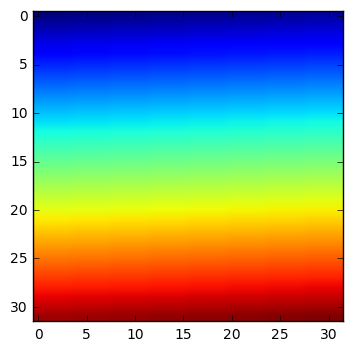

In [3]:
plt.imshow(img)

In [4]:
# This function downsamples a certain image by getting the mean in a certain cell shape
def downsample(x, cell):
    c0, c1 = cell
    yshape = (x.shape[0] // c0, x.shape[1] // c1)
    y = np.empty(yshape, x.dtype)
    for i in range(yshape[0]):
        for j in range(yshape[1]):
            y[i, j] = x[i * c0:(i + 1) * c0, j * c1: (j + 1) * c1].mean()
    return y

In [5]:
down = downsample(img, (2,2))
%timeit downsample(img, (2,2))

100 loops, best of 3: 4.32 ms per loop


Let's make sure that the generated image keeps the main treats of the original:

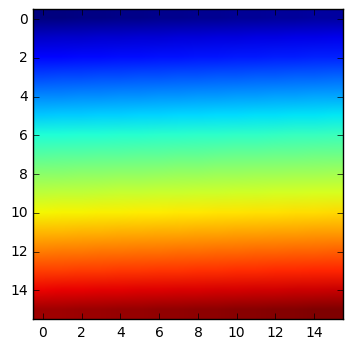

In [6]:
plt.imshow(down)

Yup, it does (at least visually).  Now, let's make sure that the new image is actually smaller:

In [7]:
img.shape, down.shape

((32, 32), (16, 16))

## Optimizing with Numba

Numba is a Just In Time (JIT) compiler that produces native code from Python sources.  It leverages LLVM technology for doing this.

In [8]:
import numba

Using it is a matter of decorating the function with the `autojit` decorator

In [9]:
@numba.autojit
def downsample_numba(x, cell):
    c0, c1 = cell
    yshape = (x.shape[0] // c0, x.shape[1] // c1)
    y = np.empty(yshape, x.dtype)
    for i in range(yshape[0]):
        for j in range(yshape[1]):
            y[i, j] = x[i * c0 : (i + 1) * c0, j*c1 : (j + 1) * c1].mean()
    return y

In [10]:
down2 = downsample_numba(img, (2,2))
%timeit down2 = downsample_numba(img, (2,2))

100000 loops, best of 3: 14.2 µs per loop


Wow, that's more than 100x faster than the Python code.

This is because the `.mean()` function **can be accelerated by Numba**.

Can we go faster than this with Numba? **Idea!**  Factorize the mean as a separate function and allow numba to JIT it.

In [11]:
@numba.autojit
def mymean(x):
    xs, ys = x.shape
    factor = 1. * xs * ys   # notice the 1. for forcing a float!
    s = 0.
    for i in range(xs):
        for j in range(ys):
            s += x[i,j] / factor
    return s

@numba.autojit
def downsample_numba2(x, cell):
    c0, c1 = cell
    yshape = (x.shape[0] // c0, x.shape[1] // c1)
    y = np.empty(yshape, x.dtype)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            #y[i, j] = x[i*c0:(i+1)*c0,j*c1:(j+1)*c1].mean()
            y[i, j] = mymean(x[i * c0 : (i + 1) * c0, j * c1 : (j + 1) * c1])
    return y

In [12]:
down3 = downsample_numba2(img, (2,2))
%timeit downsample_numba2(img, (2,2))

100000 loops, best of 3: 9.07 µs per loop


Ok, now we have a code that is 1.5x faster.  Not bad!

Always remember to check that the new algorithms are actually computing the same image than before:

In [13]:
np.allclose(down, down2)

True

In [14]:
np.allclose(down, down3)

True

Yep, they do!  Have we finished?  Or it may be possible to get more speed?

It turns out that this very same algorithm is implemented in Scikit-Image in pure C.  Let's have a try at it:

In [15]:
import skimage.transform

In [16]:
down4 = skimage.transform.downscale_local_mean(img, (2,2))

In [17]:
%timeit down4 = skimage.transform.downscale_local_mean(img, (2,2))

10000 loops, best of 3: 162 µs per loop


Hey, our Numba turbo-powered code is around 20x faster!  How that can be?

This is probably a side-effect of the Scikit Image function having to deal with some initialization overhead because it is more general.  But what happens with larger images?  We should expect this initialization overhead be less evident, right?

## Using bigger images

Let's use a more realistic image (2048x2048) and repeat the computations for all the methods above.

In [18]:
img = np.arange(2**20, dtype=np.float32).reshape(2**10, 2**10)

In [19]:
# Using just %time now (much longer execution times)
%time down = downsample(img, (2,2))

CPU times: user 4.48 s, sys: 4 ms, total: 4.48 s
Wall time: 4.48 s


In [20]:
%timeit down1 = downsample_numba(img, (2,2))

100 loops, best of 3: 13.3 ms per loop


In [21]:
%timeit down2 = downsample_numba2(img, (2,2))

100 loops, best of 3: 7.96 ms per loop


In [22]:
%timeit down3 = skimage.transform.downscale_local_mean(img, (2,2))

100 loops, best of 3: 10.4 ms per loop


Well, in this case the Scikit Image function is not the fastest yet, but close to our best Numba function.

## Cython: Getting ultimate performance

In [23]:
%load_ext Cython

In [24]:
%%cython
import numpy as np

def mymean(x):
    xs, ys = x.shape
    factor = 1. * xs * ys   # notice the 1. for forcing a float!
    s = 0.
    for i in range(xs):
        for j in range(ys):
            s += x[i,j] / factor
    return s

def downsample_cython(x, cell):
    c0, c1 = cell
    yshape = (x.shape[0] // c0, x.shape[1] // c1)
    y = np.empty(yshape, x.dtype)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            y[i, j] = mymean(x[i*c0:(i+1)*c0,j*c1:(j+1)*c1])
    return y

In [25]:
%time down = downsample_cython(img, (2,2))

CPU times: user 3.75 s, sys: 4 ms, total: 3.76 s
Wall time: 3.74 s


Wow!  That's just a hair faster than Python.  How that can be?

Well, Cython requires a bit more of user collaboration than Numba to figure out the types of the variables. Let's start giving information to Cython about types (aka **type annotation**):

In [26]:
%%cython
import numpy as np
cimport numpy as np

cdef float mymean(np.ndarray[np.float32_t, ndim=2] x):
    cdef int xs, ys
    cdef float s = 0.
    cdef int i, j
    xs, ys = x.shape[0], x.shape[1]
    for i in range(xs):
        for j in range(ys):
            s += x[i,j]
    return s / (xs * ys)

def downsample_cython2(x, cell):
    c0, c1 = cell
    yshape = (x.shape[0] // c0, x.shape[1] // c1)
    y = np.empty(yshape, x.dtype)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            y[i, j] = mymean(x[i*c0:(i+1)*c0,j*c1:(j+1)*c1])
    return y

In [27]:
down2 = downsample_cython2(img, (2,2))
%timeit down2 = downsample_cython2(img, (2,2))

1 loop, best of 3: 346 ms per loop


Hey, a 10x faster. That's a good improvement, but still far from a pure C approach:

In [28]:
%timeit down3 = skimage.transform.downscale_local_mean(img, (2,2))

100 loops, best of 3: 10.6 ms per loop


Let's proceed with more annotations:

In [30]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.cdivision(True)
cdef float mymean(np.ndarray[np.float32_t, ndim=2] x):
    cdef int xs, ys
    cdef float s = 0.
    cdef int i, j
    xs, ys = x.shape[0], x.shape[1]
    for i in range(xs):
        for j in range(ys):
            s += x[i,j]
    return s / (xs * ys)

@cython.boundscheck(False)
def downsample_cython3(np.ndarray[np.float32_t, ndim=2] x, cell):
    cdef int c0 = cell[0], c1 = cell[1]
    cdef int ys0 = x.shape[0] // c0
    cdef int ys1 = x.shape[1] // c1
    cdef int i, j
    cdef np.ndarray[np.float32_t, ndim=2] y = np.empty((ys0, ys1), x.dtype)
    for i in range(ys0):
        for j in range(ys1):
            y[i, j] = mymean(x[i*c0:(i+1)*c0,j*c1:(j+1)*c1])
    return y

In [31]:
%timeit down4 = downsample_cython3(img, (2,2))

1 loop, best of 3: 287 ms per loop


But the performance is still pretty bad compared with Scikit Image.  What's up?

Enter `cython -a` for looking at some profile.

Aha, seems like creating numpy view is a costly operation.  Let's use memory views:

In [32]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.cdivision(True)
cdef float mymean(float [:,:] x):
    cdef int xs, ys
    cdef float s = 0.
    cdef int i, j
    xs, ys = x.shape[0], x.shape[1]
    for i in range(xs):
        for j in range(ys):
            s += x[i,j]
    return s / (xs * ys)

@cython.boundscheck(False)
def downsample_cython4(x, cell):
    cdef int c0 = cell[0], c1 = cell[1]
    cdef int ys0 = x.shape[0] // c0
    cdef int ys1 = x.shape[1] // c1
    cdef int i, j
    y = np.empty((ys0, ys1), x.dtype)
    cdef float [:, :] y_view = y 
    cdef float [:, :] x_view = x 
    for i in range(ys0):
        for j in range(ys1):
            y_view[i, j] = mymean(x_view[i*c0:(i+1)*c0,j*c1:(j+1)*c1])
    return y

In [33]:
%timeit down5 = downsample_cython4(img, (2,2))

100 loops, best of 3: 10.1 ms per loop


Looks pretty good now!  Let's remember the speed of Scikit Image:

In [34]:
%timeit down3 = skimage.transform.downscale_local_mean(img, (2,2))

100 loops, best of 3: 10.5 ms per loop


Wow! we are getting barely the same performance than Scikit-Image.  We are done!  Or perhaps not yet?

## Introducing the `prange` for Cython (easy OpenMP for Cython)

In [35]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.cdivision(True)
cdef float mymean(float [:,:] x) nogil:
    cdef int xs, ys
    cdef float s = 0.
    cdef int i, j
    xs, ys = x.shape[0], x.shape[1]
    for i in prange(xs):
    #for i in prange(xs, schedule='static'):  # give this a try
        for j in range(ys):
            s += x[i,j]
    return s / (xs * ys)

@cython.boundscheck(False)
def downsample_cython5(x, cell):
    cdef int c0 = cell[0], c1 = cell[1]
    cdef int ys0 = x.shape[0] // c0
    cdef int ys1 = x.shape[1] // c1
    cdef int i, j
    y = np.empty((ys0, ys1), x.dtype)
    cdef float [:, :] y_view = y 
    cdef float [:, :] x_view = x
    with nogil:
        for i in range(ys0):
            for j in range(ys1):
                y_view[i, j] = mymean(x_view[i*c0:(i+1)*c0,j*c1:(j+1)*c1])
    return y

In [36]:
%timeit down5 = downsample_cython5(img, (2,2))

100 loops, best of 3: 9.2 ms per loop


Ok, not a lot of improvement.  Let's try with reducing the function call overhead.

## Fusion loop for Cython

In [37]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange


@cython.boundscheck(False)
@cython.cdivision(True)
def downsample_cython6(x, cell):
    cdef int c0 = cell[0], c1 = cell[1]
    cdef int ys0 = x.shape[0] // c0
    cdef int ys1 = x.shape[1] // c1
    cdef int i, j, ii, jj
    y = np.empty((ys0, ys1), x.dtype)
    cdef float [:, :] x_view = x 
    cdef float [:, :] y_view = y 
    cdef float s = 0.
    with nogil:
        for i in range(ys0):
            for j in range(ys1):
                s = 0.
                for ii in prange(c0):
                    for jj in range(c1):
                        s += x_view[i*c0 + ii, j*c1 + jj]
                y_view[i, j] = s / (c0 * c1)
    return y

In [38]:
down6 = downsample_cython6(img, (2,2))
%timeit down6 = downsample_cython6(img, (2,2))

1000 loops, best of 3: 1.93 ms per loop


Cool, we have got another 5x acceleration, and the best mark so far.  Do not forget to check that we are still getting the same results.

In [39]:
np.allclose(down2, down6)

True

In general, when doing parallelism, you can expect different degrees of speedups, depending on the kind of computations performed.

Just remember the speed that we got with Scikit Image and our best shot with Numba:

In [40]:
%timeit skimage.transform.downscale_local_mean(img, (2,2))

100 loops, best of 3: 10.9 ms per loop


In [41]:
%timeit downsample_numba2(img, (2,2))

100 loops, best of 3: 8.03 ms per loop


So not bad, our Cython code can go more than 4x faster than Numba and more than 5x faster than Scikit Image!

## Fusion loop for Numba

In [65]:
@numba.autojit
def downsample_numba3(x, cell):
    c0, c1 = cell
    yshape = (x.shape[0] // c0, x.shape[1] // c1)
    y = np.empty(yshape, x.dtype)
    factor = c0 * c1
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            #y[i, j] = mymean(x[i * c0 : (i + 1) * c0, j * c1 : (j + 1) * c1])
            s = 0.
            for ii in range(c0):
                for jj in range(c1):
                    s += x[i*c0 + ii, j*c1 + jj]
            y[i, j] = s / (c0 * c1)
    return y

In [69]:
down3 = downsample_numba3(img, (2,2))
%timeit downsample_numba3(img, (2,2))

100 loops, best of 3: 2.03 ms per loop


In [67]:
np.allclose(down2, down3)

True

## Final summary of our optimization efforts

In [68]:
%timeit downsample(img, (2,2))

1 loop, best of 3: 4.63 s per loop


In [70]:
%timeit downsample_numba(img, (2,2))

100 loops, best of 3: 13.5 ms per loop


In [71]:
%timeit downsample_numba2(img, (2,2))

100 loops, best of 3: 7.98 ms per loop


In [72]:
%timeit skimage.transform.downscale_local_mean(img, (2,2))

100 loops, best of 3: 10.9 ms per loop


In [73]:
%timeit downsample_cython4(img, (2,2))

100 loops, best of 3: 9.95 ms per loop


In [74]:
%timeit downsample_cython6(img, (2,2))

1000 loops, best of 3: 1.96 ms per loop


In [75]:
%timeit downsample_numba3(img, (2,2))

100 loops, best of 3: 2.04 ms per loop


In general, we are going to get our best performance with Cython, but Numba is getting very close, and requiring **much less effort** on programmer's side.


### Using a larger cell (32x32)

In [78]:
%timeit skimage.transform.downscale_local_mean(img, (32,32))

100 loops, best of 3: 3.59 ms per loop


In [76]:
%timeit downsample_cython6(img, (32,32))

1000 loops, best of 3: 1.3 ms per loop


In [77]:
%timeit downsample_numba3(img, (32,32))

1000 loops, best of 3: 1.21 ms per loop


We see that our optimized code is still faster than scikit-image, and Numba has a hair of advantage over Cython here.

## Exercise: Optimizing a Mandelbrot computation

Provided this code that computes the Madelbrot set:

In [ ]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()


Find a way to optimize it by using the techniques described in this tutorial.